# Dopamine modulation on BG

**Observation**: increase in beta-range spectral power is observed without dopamine modulation of CTX input to MSN-D1 and MSN-D2.

**Method**: I used the network model from Ortone and the model of dopamine modulation from Lindahl(2016). In particular, if an attribute $x$ of the network is subject to dopaminergic modulation, the effect of dopamine levels are modeled by

$$ x(\alpha) = x_0(1+\chi_x (\alpha -\alpha_0))$$
where $\alpha$ represents the dopamine level and $x_0$ is the value of the parameter at standard dopamine ($\alpha_0 = 0.8$, Lindahl). In the following, $\chi_x$ will be called generalized susceptibility.

The **main differences** between Ortone and Lindahl networks are:

- size of populations
- STN subthreshold/suprathreshold adaptation parameter ada_a (Ortone: 0, Lindahl 0.3)
- Rest potential of FSN (Ortone: -80, Lindahl: -64.4). This attribute is negatively susceptible to dopamine, so FSN in Lindahl's network is already dopamine-depleted w.r.t. Ortone's network;
- SNr synaptic fan-in (from MSN-D1 Ortone: 59, Lindahl: 500; from GPeTI Ortone:25, Lindahl: 32 ). This is not particularly relevant for now since SNr is an output;
- External/Cortical input rates. In Ortone rates are 2-3 times the rates in Lindahl.
- synaptic model

In [171]:
import yaml
from rich import print

NEURONS_FILE = "ortone_neurons.yaml"
NETWORK_FILE = "ortone_network_dispersive.yaml"
DOPAMINE_FILE = "lindahl_dopamine_susceptibility.yaml"
DISPERSION_FILE = "dispersive_susceptibility.yaml"

print("List of dopamine-dependent attributes:")
with open(DOPAMINE_FILE, "r") as dopfile:
    susceptiblities = yaml.safe_load(dopfile)['parametric']['dopamine']

for item in susceptiblities:
    if 'population' in item.keys():
        print(f"Attribute {item['attribute']:15} of population {item['population']:15}: chi = {item['susceptibility']}")
    elif 'projection' in item.keys():
        print(f"Attribute {item['attribute']:10} of projection {item['projection']:15}: chi = {item['susceptibility']}")

List of dopamine-dependent attributes:

Attribute E_l             of population FSN            : chi = -0.078

Attribute E_l             of population GPeTA, GPeTI   : chi = -0.181

Attribute V_peak          of population D1             : chi = 0.0296

Attribute ada_b           of population D1             : chi = -0.45

Attribute E_l             of population SNR            : chi = -0.0896

Attribute weight     of projection FSN->FSN       : chi = -1.27

Attribute weight     of projection GPeTA->FSN     : chi = -0.53

Attribute weight     of projection GPeTI->FSN     : chi = -0.53

Attribute weight     of projection GPeTA->GPeTA, GPeTA->GPeTI, GPeTI->GPeTI,  GPeTI->GPeTA: chi = -0.83

Attribute weight     of projection D2->GPeTI      : chi = -0.83

Attribute weight     of projection STN->GPeTA     : chi = -0.45

Attribute weight     of projection STN->GPeTI     : chi = -0.45

Attribute connectivity of projection FSN->D2        : chi = -0.9

Attribute connectivity of projection D1->D1, D1->D2, D2->D1, D2->D2: chi = 0.88

Attribute weight     of projection D1->D1, D1->D2, D2->D1, D2->D2: chi = 0.88

Attribute weight     of projection GPeTA->D1      : chi = -1.15

Attribute weight     of projection D1->SNR        : chi = 0.56

Attribute weight     of projection GPeTI->STN     : chi = -0.24

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext wurlitzer
%matplotlib inline
# %matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


## Parameters of the simulation

In [201]:
Tlong = 8000  # ms
dt = 0.1      # ms

points_per_bin = 1/dt     # bins 1 ms wide
sampling_frequency = 1e3  # 1 kHz sampling frequency
burn_in_millis = 600      # the first part of the record to discard (ms)

# Params for trials
n_trials = 10
Tshort = 1500 # ms

# Rescaling of populations: Lindahl network is unbearable on my machine
# so populations are rescaled to match sizes from Ortone
populations_scaling = dict()
if NETWORK_FILE == "lindahl_network.yaml":
    populations_scaling = dict( MSN_scale= -0.84,
                                FSN_scale= -0.74,
                                GPe_scale= -0.22,
                                STN_scale= 0.05
                                )

reasonable_firing = dict(FSN=15, D1=1.5, D2=1.5, GPeTI=50, GPeTA=10, STN=16)
# FSN [10-20] Hz 
# D1, D2 [0.5–2.5] Hz
# GPe-TI [40–60] Hz
# GPe-TA [5–15] Hz 
# and STN [12–20] Hz


## Utils & plots

In [174]:
from scipy.signal import butter, sosfiltfilt, freqz, welch
from scipy.integrate import simpson
from scipy import stats

def bin_spikes(spikes, points_per_bin = 10):
    binned_signal = np.sum( spikes[:(len(spikes)//points_per_bin)*points_per_bin].reshape(-1, points_per_bin),
                        axis=1).squeeze()
    return binned_signal

def beta_power(sn, population):    
    spikes = sn.populations[population].get_data('spikes')
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    T = len(binned_spikes)
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = T/2, # Takes at least 3 windows
                   noverlap= T/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    norm = simpson(PSD, x=f)
    # print(f"f peak of {population} is {f[np.argmax(PSD)]} Hz")
    beta_mask = (f>12)&(f<30)
    beta_pow = simpson(PSD[beta_mask], x=f[beta_mask])
    # freq of max, normlized beta power, beta power, entropy
    return f[np.argmax(PSD)], beta_pow/norm, beta_pow, stats.entropy(PSD/norm)

def bandpass(data, edges, sample_rate, poles = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

def get_PSD(sn, pop, frequency_resolution=0.5, smooth=False):
    spikes = sn.populations[pop].get_data('spikes')
    binned_spikes = bin_spikes(spikes)
    binned_spikes = binned_spikes[burn_in_millis:]
    T = len(binned_spikes)
    # print(f"Mean firing rate {pop} is {np.sum(spikes)/sn.populations[pop].n_neurons/(Tlong/1000) :.1f} Hz")

    N = sampling_frequency/frequency_resolution
    
    if N > T/2:
        print(N)
        print(f"Not enough points to achieve resolution of {frequency_resolution}")
        N = T/2

    nfft = 10_000 if smooth else None
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg=N, 
                   noverlap=N/2,
                   nfft=nfft,
                   scaling='density', 
                   window='hamming')
    # print(f"F resolution { f[1] - f[0] :.2f} Hz")
    norm = simpson(PSD, x=f)
    return f, PSD

In [175]:
def plot_spectrum(sn, scale="log", pops=None):
    if pops is None:
        pops = sn.populations
    fig, axes = plt.subplots(len(pops), 1, sharex=True)
    for ax, pop in zip(axes, pops):
        f, PSD = get_PSD(sn, pop)
        norm = simpson(PSD, x=f)
        ax.plot(f, PSD/norm, label=pop)
        
        ax.set_ylabel(pop)
        ax.set_yscale(scale)
    print(f"F resolution { f[1] - f[0] :.2f} Hz")
    # plt.yscale('log')
    # plt.legend()
    # plt.ylabel("normalized PSD")
    plt.xlabel("Frequency [Hz]")
    plt.xlim(10, 30)
    fig.set_figheight(8.5)

def plot_signals(sn, pops=None):
    if pops is None:
        pops = sn.populations.keys()
    fig, axes = plt.subplots(len(pops), 1, sharex=True)
    for ax, pop in zip(axes, pops):
        binned_spikes = bin_spikes(sn.populations[pop].get_data('spikes'))
        instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
        
        tt = np.linspace(0, len(instantaneous_fr)/1000, len(instantaneous_fr))
        ax.plot(tt, instantaneous_fr)
        ax.plot(tt, bandpass(instantaneous_fr, [12, 30], sampling_frequency), label="beta")
        ax.plot(tt, bandpass(instantaneous_fr, [30, 140], sampling_frequency), label="gamma")
        ax.set_ylabel(pop)
    # ax.set_xlim(1.5, 2)
    fig.suptitle("Instantaneous firing rate [Hz]")
    ax.set_xlabel("time [s]")
    fig.set_figheight(8.5)

## Building the network

In [176]:
from quilt.interface.spiking import set_verbosity
set_verbosity(1)

In [178]:
from quilt.builder import NeuronCatalogue, ParametricSpikingNetwork

sn = ParametricSpikingNetwork.from_yaml(NETWORK_FILE, 
                                        NEURONS_FILE,
                                        [DOPAMINE_FILE, 
                                         DISPERSION_FILE, "dbs.yaml"])
sn.monitorize_spikes()
# sn.monitorize_states("GPeTA")

## Control case (healthy subject)

In [295]:
sn.set_parameters(dopamine=1.0, delay_dispersion=-1, **populations_scaling)
sn.run(dt=dt, time=Tlong)

Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 148 s	(1.85252 ms/step)
	Gathering time avg: 0.033625 us/step
	Inject time avg: 197.956 us/step
Population evolution stats:
	0:
		evolution:	509.773 us/step	---	84 ns/step/neuron
		spike emission:	66.112 us/step	---	11 ns/step/neuron
	1:
		evolution:	458.579 us/step	---	76 ns/step/neuron
		spike emission:	91.0293 us/step	---	15 ns/step/neuron
	2:
		evolution:	92.0849 us/step	---	219 ns/step/neuron
		spike emission:	14.566 us/step	---	34 ns/step/neuron
	3:
		evolution:	117.283 us/step	---	150 ns/step/neuron
		spike emission:	26.279 us/step	---	33 ns/step/neuron
	4:
		evolution:	66.2023 us/step	---	254 ns/step/neuron
		spike emission:	7.00051 us/step	---	26 ns/step/neuron
	5:
		evolution:	74.3376 us/step	---	182 ns/step/neuron
		spike emission:	5.8875 us/step	---	14 ns/step/neuron
	6:
		evolution:	111.368 us/

IOStream.flush timed out


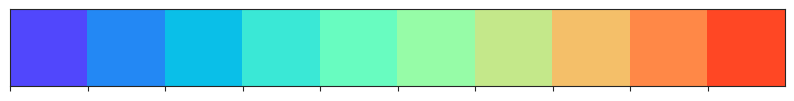

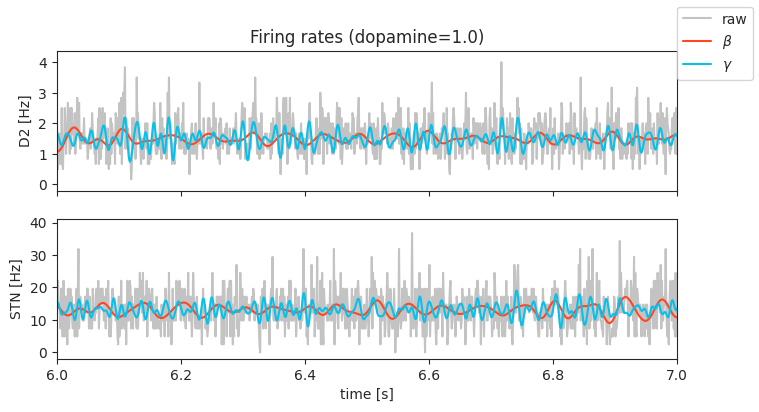

In [298]:
colors = sns.color_palette("rainbow", 10)
sns.palplot(colors)
fig, ax = plt.subplot_mosaic([["D2"], ["STN"]],sharex=True, figsize=(8,4))
ax['D2'].set_title("Firing rates (dopamine=1.0)")
for pop in ['D2', 'STN']:    
    binned_spikes = bin_spikes(sn.populations[pop].get_data('spikes'))
    instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
    
    tt = np.linspace(0, len(instantaneous_fr)/1000, len(instantaneous_fr))
    ax[pop].plot(tt, instantaneous_fr, color="#c3c3c3", label="raw")
    # ax['signal'].axhline(np.mean(instantaneous_fr), ls="-", color=colors[2])
    # ax['signal'].axhline(reasonable_firing[pop], ls=":", color=colors[-1])

        
    ax[pop].plot(tt,np.mean(instantaneous_fr) + bandpass(instantaneous_fr, [12, 30], sampling_frequency), label=r"$\beta$", color=colors[9])
    ax[pop].plot(tt, np.mean(instantaneous_fr)  + bandpass(instantaneous_fr, [30, 90], sampling_frequency), label=r"$\gamma$", color=colors[2])
    
    ax[pop].set_xlim(6, 7)
    ax[pop].set_ylabel(f"{pop} [Hz]")
    ax[pop].legend()

leg = ax['D2'].get_legend()
for a in ax.values():
    a.legend().remove()

fig.legend(handles=leg.legend_handles, loc='upper right')

ax["STN"].set_xlabel("time [s]")
plt.savefig("images/firing_rates_1.pdf")
plt.show()


## Lesioned case (PD)

In [299]:
sn.set_parameters(dopamine=0.4, delay_dispersion=-1, **populations_scaling)
sn.run(dt=dt, time=Tlong)

Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 157 s	(1.97422 ms/step)
	Gathering time avg: 0.0479125 us/step
	Inject time avg: 205.147 us/step
Population evolution stats:
	0:
		evolution:	551.396 us/step	---	91 ns/step/neuron
		spike emission:	96.4453 us/step	---	16 ns/step/neuron
	1:
		evolution:	494.198 us/step	---	82 ns/step/neuron
		spike emission:	77.6784 us/step	---	12 ns/step/neuron
	2:
		evolution:	94.7415 us/step	---	225 ns/step/neuron
		spike emission:	15.8647 us/step	---	37 ns/step/neuron
	3:
		evolution:	124.807 us/step	---	160 ns/step/neuron
		spike emission:	22.3018 us/step	---	28 ns/step/neuron
	4:
		evolution:	68.972 us/step	---	265 ns/step/neuron
		spike emission:	5.26444 us/step	---	20 ns/step/neuron
	5:
		evolution:	77.4084 us/step	---	189 ns/step/neuron
		spike emission:	6.84947 us/step	---	16 ns/step/neuron
	6:
		evolution:	118.342

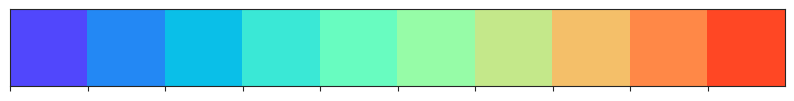

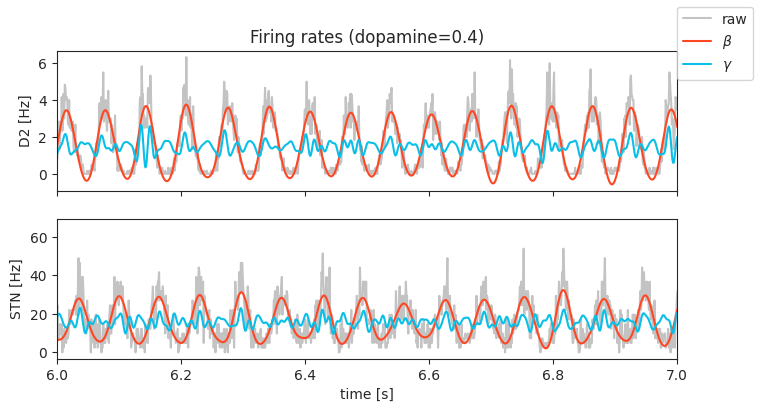

In [300]:
colors = sns.color_palette("rainbow", 10)
sns.palplot(colors)
fig, ax = plt.subplot_mosaic([["D2"], ["STN"]],sharex=True, figsize=(8,4))
ax['D2'].set_title("Firing rates (dopamine=0.4)")
for pop in ['D2', 'STN']:    
    binned_spikes = bin_spikes(sn.populations[pop].get_data('spikes'))
    instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
    
    tt = np.linspace(0, len(instantaneous_fr)/1000, len(instantaneous_fr))
    ax[pop].plot(tt, instantaneous_fr, color="#c3c3c3", label="raw")
    # ax['signal'].axhline(np.mean(instantaneous_fr), ls="-", color=colors[2])
    # ax['signal'].axhline(reasonable_firing[pop], ls=":", color=colors[-1])

        
    ax[pop].plot(tt,np.mean(instantaneous_fr) + bandpass(instantaneous_fr, [12, 30], sampling_frequency), label=r"$\beta$", color=colors[9])
    ax[pop].plot(tt, np.mean(instantaneous_fr)  + bandpass(instantaneous_fr, [30, 90], sampling_frequency), label=r"$\gamma$", color=colors[2])
    
    ax[pop].set_xlim(6, 7)
    ax[pop].set_ylabel(f"{pop} [Hz]")
    ax[pop].legend()

leg = ax['D2'].get_legend()
for a in ax.values():
    a.legend().remove()

fig.legend(handles=leg.legend_handles, loc='upper right')

ax["STN"].set_xlabel("time [s]")
plt.savefig("images/firing_rates_04.pdf")
plt.show()


## Comparison

In [111]:
dopamines = [0.4, 0.7, 1]

# nets = []
# for dopamine in dopamines:
#     nets.append(ParametricSpikingNetwork.from_yaml(NETWORK_FILE, 
#                                             NEURONS_FILE,
#                                             [DOPAMINE_FILE, 
#                                              DISPERSION_FILE, "dbs.yaml"]))
#     nets[-1].set_parameters(dopamine=dopamine, delay_dispersion=-1, **populations_scaling)
#     nets[-1].monitorize_spikes()

In [83]:
# for net in nets:
#     net.run(dt=dt, time=Tlong)

Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 128 s	(1.60526 ms/step)
	Gathering time avg: 0.121875 us/step
	Inject time avg: 161.655 us/step
Population evolution stats:
	0:
		evolution:	437.684 us/step	---	72 ns/step/neuron
		spike emission:	56.9434 us/step	---	9 ns/step/neuron
	1:
		evolution:	417.401 us/step	---	69 ns/step/neuron
		spike emission:	50.9239 us/step	---	8 ns/step/neuron
	2:
		evolution:	82.8576 us/step	---	197 ns/step/neuron
		spike emission:	12.9802 us/step	---	30 ns/step/neuron
	3:
		evolution:	108.802 us/step	---	139 ns/step/neuron
		spike emission:	17.8903 us/step	---	22 ns/step/neuron
	4:
		evolution:	59.5934 us/step	---	229 ns/step/neuron
		spike emission:	3.53969 us/step	---	13 ns/step/neuron
	5:
		evolution:	69.6581 us/step	---	170 ns/step/neuron
		spike emission:	5.44036 us/step	---	13 ns/step/neuron
	6:
		evolution:	106.48 us

IOStream.flush timed out


Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 135 s	(1.69938 ms/step)
	Gathering time avg: 0.273025 us/step
	Inject time avg: 173.463 us/step
Population evolution stats:
	0:
		evolution:	472.719 us/step	---	78 ns/step/neuron
		spike emission:	63.6523 us/step	---	10 ns/step/neuron
	1:
		evolution:	433.565 us/step	---	72 ns/step/neuron
		spike emission:	61.7109 us/step	---	10 ns/step/neuron
	2:
		evolution:	83.4473 us/step	---	198 ns/step/neuron
		spike emission:	13.0844 us/step	---	31 ns/step/neuron
	3:
		evolution:	111.543 us/step	---	143 ns/step/neuron
		spike emission:	20.5932 us/step	---	26 ns/step/neuron
	4:
		evolution:	60.8894 us/step	---	234 ns/step/neuron
		spike emission:	3.97026 us/step	---	15 ns/step/neuron
	5:
		evolution:	71.4474 us/step	---	175 ns/step/neuron
		spike emission:	5.51754 us/step	---	13 ns/step/neuron
	6:
		evolution:	109.818

IOStream.flush timed out


F resolution 0.10 Hz

F resolution 0.10 Hz

F resolution 0.10 Hz

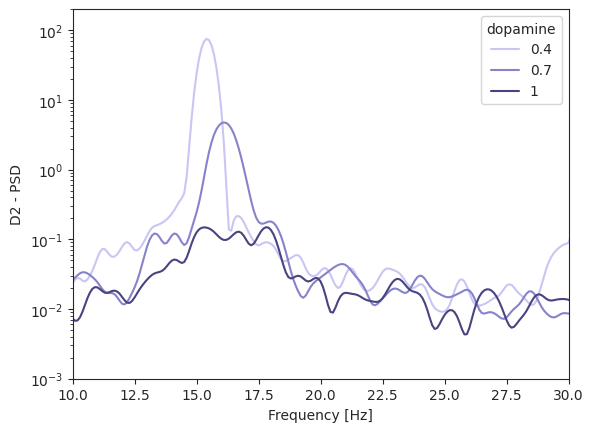

In [138]:
# fig, ax = plt.subplots()
# D2_colors = sns.cubehelix_palette(start=0, rot=0, dark=0.3, light=0.8, reverse=False, n_colors=3, hue=1)
# STN_colors = sns.cubehelix_palette(start=1.3, rot=0, dark=0.3, light=0.8, reverse=False, n_colors=3, hue=1)

# sns.set_style("ticks")

# for i in range(3):
#     ax.plot(*get_PSD(nets[i], "D2", frequency_resolution=0.5, smooth=True), label=dopamines[i], color=D2_colors[i])
#     # ax.plot(*get_PSD(nets[i], "STN"), label="STN", color=STN_colors[i])
# ax.set_yscale('log')
# ax.set_xlim(10, 30)
# plt.legend(title="dopamine")
# ax.set_xlabel("Frequency [Hz]")
# ax.set_ylabel("D2 - PSD")
# ax.set_ylim(1e-3, 2e2)
# plt.savefig("images/D2-PSD.pdf")

F resolution 0.10 Hz

F resolution 0.10 Hz

F resolution 0.10 Hz

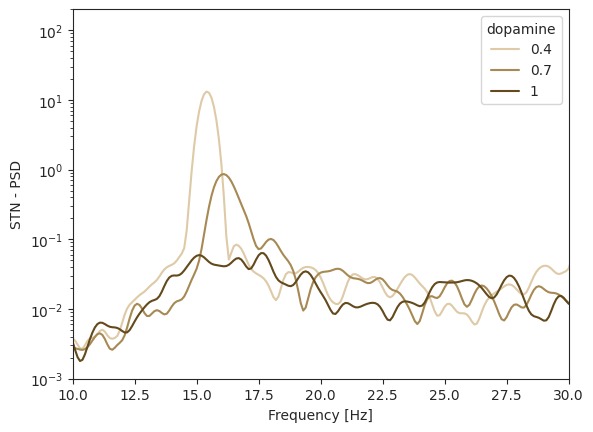

In [139]:
# fig, ax = plt.subplots()
# STN_colors = sns.cubehelix_palette(start=1.3, rot=0, dark=0.3, light=0.8, reverse=False, n_colors=3, hue=1)

# sns.set_style("ticks")

# for i in range(3):
#     ax.plot(*get_PSD(nets[i], "STN", frequency_resolution=0.5, smooth=True), label=dopamines[i], color=STN_colors[i])
#     # ax.plot(*get_PSD(nets[i], "STN"), label="STN", color=STN_colors[i])
# ax.set_yscale('log')
# ax.set_xlim(10, 30)
# plt.legend(title="dopamine")
# ax.set_xlabel("Frequency [Hz]")
# ax.set_ylabel("STN - PSD")
# ax.set_ylim(1e-3, 2e2)
# plt.savefig("images/STN-PSD.pdf")

## Trend

In [141]:
from rich.progress import track

set_verbosity(0)
beta_powers = dict()
fmaxs = dict()
beta_powers_normalized = dict()
entropies = dict()

for pop in sn.spike_monitored_pops:
    fmaxs[pop] = []
    beta_powers[pop] = []
    beta_powers_normalized[pop] = []
    entropies[pop] = []
    
dopamine_levels = np.linspace(0.2, 0.9, 20)
delay_dispersions = np.linspace(-1,2,30)

for dopamine in track(dopamine_levels, total=len(dopamine_levels)):
    sn.set_parameters(dopamine=dopamine, delay_dispersion=-1, **populations_scaling)
    sn.run(dt=dt, time=1600)
    for pop in sn.populations.keys():
        fmax, normbeta, beta, entropy = beta_power(sn, pop)
        fmaxs[pop] += [fmax]
        beta_powers_normalized[pop] += [normbeta]
        beta_powers[pop] += [beta]
        entropies[pop] += [entropy]

Output()

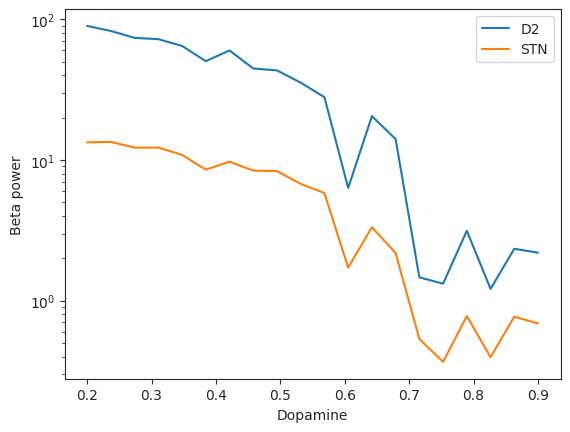

In [147]:
for pop in ["D2", "STN"]:
    plt.plot(dopamine_levels, beta_powers[pop], label=pop)
plt.ylabel("Beta power")
plt.xlabel("Dopamine")
plt.yscale('log')
plt.legend()

(0.0, 30.0)

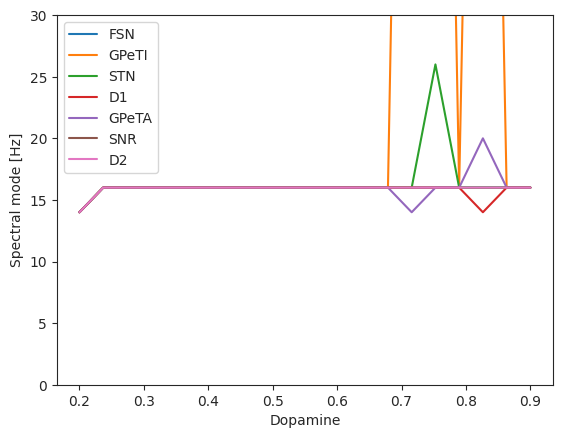

In [143]:
for pop in fmaxs:
    plt.plot(dopamine_levels, fmaxs[pop], label=pop)
# plt.yscale('log')
plt.ylabel("Spectral mode [Hz]")
plt.xlabel("Dopamine")
plt.legend()
plt.ylim(0, 30)

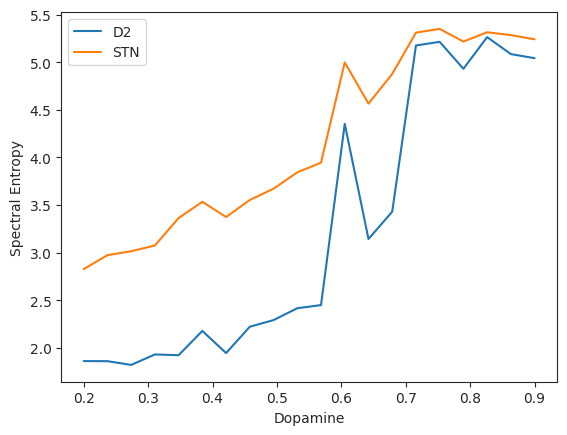

In [148]:
for pop in ["D2", "STN"]:
    plt.plot(dopamine_levels, entropies[pop], label=pop)
# plt.yscale('log')
plt.xlabel("Dopamine")
plt.ylabel("Spectral Entropy")
plt.legend()

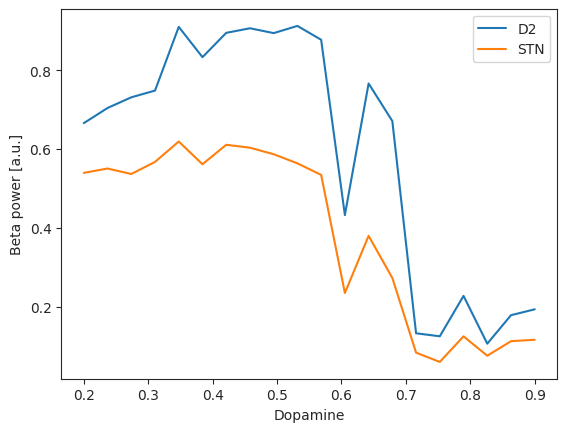

In [149]:
for pop in ["D2", "STN"]:
    plt.plot(dopamine_levels, beta_powers_normalized[pop], label=pop)
# plt.yscale('log')
plt.ylabel("Beta power [a.u.]")
plt.xlabel("Dopamine")
plt.legend()

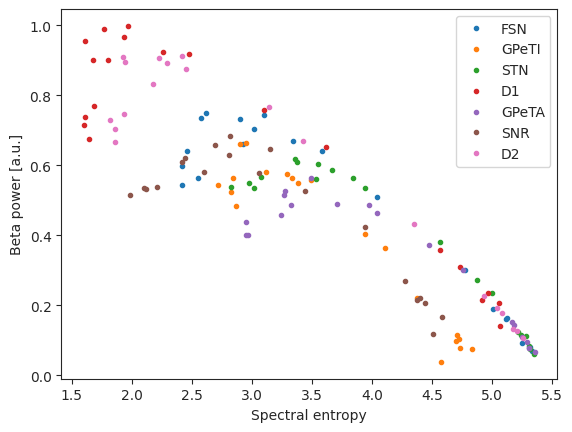

In [146]:
for pop in beta_powers_normalized:
    plt.plot(entropies[pop], beta_powers_normalized[pop], label=pop, ls="", marker=".")
plt.xlabel("Spectral entropy")
plt.ylabel("Beta power [a.u.]")
plt.legend()

## plot 2D

In [154]:
from scipy.integrate import simpson
def bin_spectrum(f, PSD, n_bins=20, fmax=90):
    norm = simpson(PSD[f<fmax], x=f[f<fmax])
    
    binned_spectrum = np.zeros(n_bins)
    frequency_bin_width = fmax/n_bins
    for i in range(n_bins):
        f_mask = (f > i*frequency_bin_width)&(f < (i+1)*frequency_bin_width)
        # binned_spectrum[i] = simpson(PSD[f_mask], x=f[f_mask])/norm
    return binned_spectrum

In [165]:
from rich.progress import track

set_verbosity(0)

spectral_resolution = 2.5
N_dopamine_levels = int(90/spectral_resolution)
N_spectral_bins = int(90/spectral_resolution)
dopamine_levels = np.linspace(0.2, 1.0, N_dopamine_levels)

spectra = dict()
for pop in sn.features_dict['populations']:
    spectra[pop] = np.zeros((N_dopamine_levels, N_spectral_bins))

for i in track(range(N_dopamine_levels), total=len(dopamine_levels)):
    sn.set_parameters(dopamine=dopamine_levels[i], 
                      delay_dispersion=-1, 
                      **populations_scaling)
    sn.run(dt=dt, time=3 * sampling_frequency/spectral_resolution + burn_in_millis ) # Uses 3 complete windows at minimal resolution
    for pop in sn.populations.keys():
        f, PSD = get_PSD(sn, pop, frequency_resolution=spectral_resolution)
        plt.show()
        spectra[pop][i] = PSD[f<90]
    

Output()

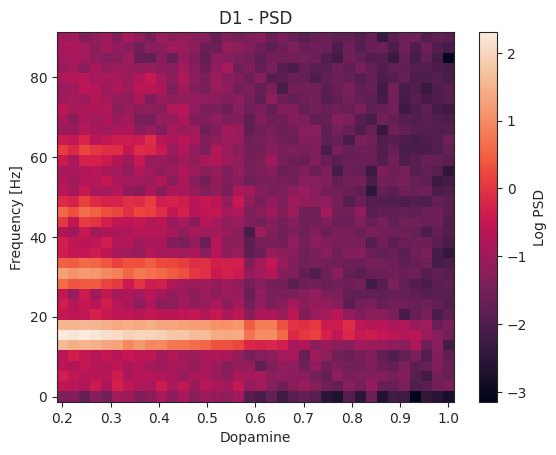

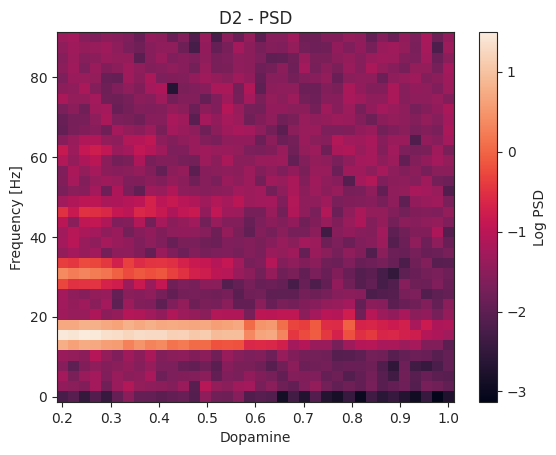

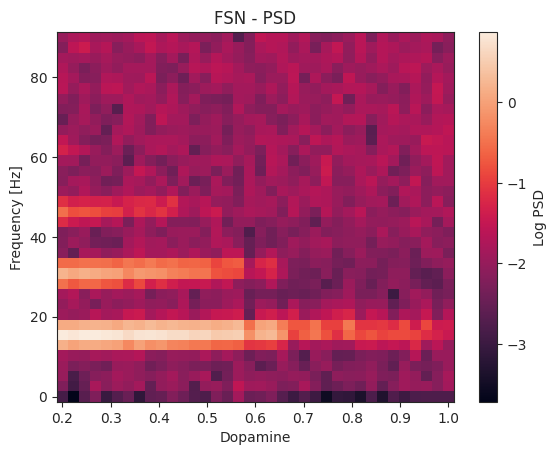

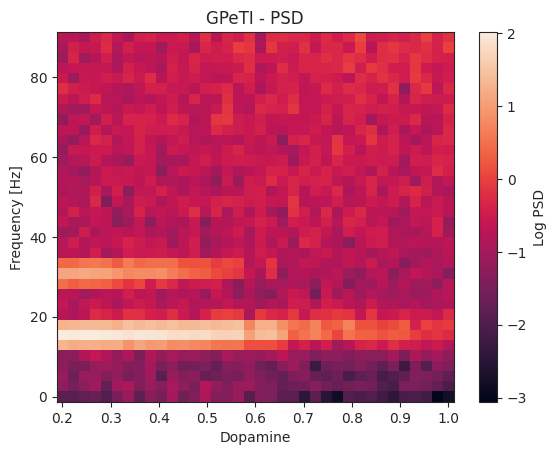

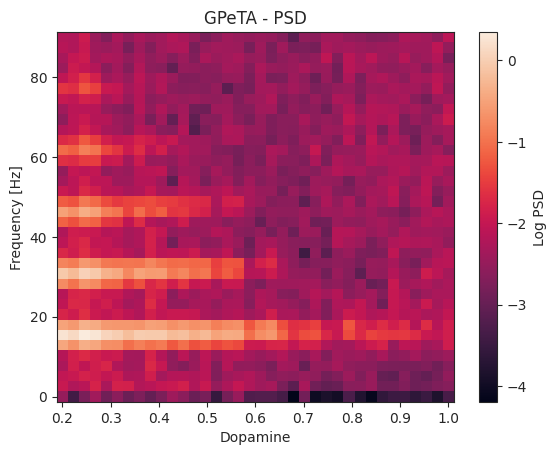

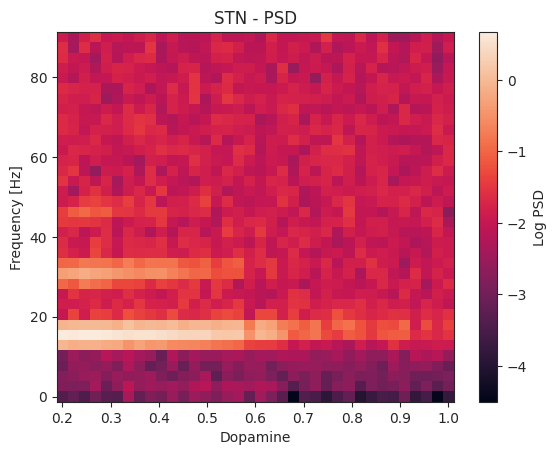

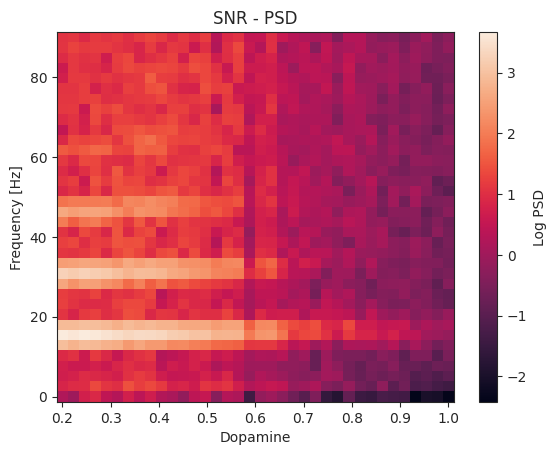

In [167]:
# X, Y = np.meshgrid(dopamine_levels, np.linspace(0, 90, int(90/spectral_resolution)))
# # pop = "GPeTA"
# for pop in sn.populations:
#     plt.pcolormesh(X, Y, np.log10(spectra[pop].T + 1e-10))
#     plt.xlabel("Dopamine")
#     plt.ylabel("Frequency [Hz]")
#     plt.colorbar(label = "Log PSD")
#     plt.title(f"{pop} - PSD")
#     plt.savefig(f"images/logPSD_{pop}.pdf")
#     plt.show()